In [59]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [61]:
import warnings

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.xarray

from deformtools.tools import da_median, get_ci, get_percentiles, alphabet

sns.set(style='ticks', context='paper', palette='colorblind',font_scale=1.3)
mpl.rc('figure', dpi=100, figsize=[11, 5])
mpl.rc('savefig', dpi=500, bbox='tight')
mpl.rc('legend', frameon=False)

warnings.simplefilter('ignore')

In [62]:
dat = xr.open_mfdataset('../data/clusters/combinations_lt_10_*.nc',concat_dim='clusters',)
dat = dat.sel(time=slice('2015-09-02 20:00','2015-09-12'))

In [65]:
dat = dat.resample(time='2H').mean()

In [66]:
# choose subsedat.sel

<xarray.Dataset>
Dimensions:  (clusters: 48198, id: 45, time: 122)
Coordinates:
  * time     (time) datetime64[ns] 2015-09-02T20:00:00 ... 2015-09-12T22:00:00
  * id       (id) int64 0 1 2 3 4 5 6 7 8 9 10 ... 35 36 37 38 39 40 41 42 43 44
Dimensions without coordinates: clusters
Data variables:
    lon      (time, clusters, id) float32 dask.array<chunksize=(1, 2000, 45), meta=np.ndarray>
    lat      (time, clusters, id) float32 dask.array<chunksize=(1, 2000, 45), meta=np.ndarray>
    sst      (time, clusters, id) float32 dask.array<chunksize=(1, 2000, 45), meta=np.ndarray>
    sal      (time, clusters, id) float32 dask.array<chunksize=(1, 2000, 45), meta=np.ndarray>
    u        (time, clusters, id) float64 dask.array<chunksize=(1, 2000, 45), meta=np.ndarray>
    v        (time, clusters, id) float64 dask.array<chunksize=(1, 2000, 45), meta=np.ndarray>
    ux       (time, clusters) float64 dask.array<chunksize=(1, 2000), meta=np.ndarray>
    uy       (time, clusters) float64 dask.array<chunksize=(1, 2000), meta=np.ndarray>
    vx       (time, clusters) float64 dask.array<chunksize=(1, 2000), meta=np.ndarray>
    vy       (time, clusters) float64 dask.array<chunksize=(1, 2000), meta=np.ndarray>
    aspect   (time, clusters) float64 dask.array<chunksize=(1, 2000), meta=np.ndarray>
    angle    (time, clusters) float64 dask.array<chunksize=(1, 2000), meta=np.ndarray>
    length   (time, clusters) float64 dask.array<chunksize=(1, 2000), meta=np.ndarray>
    vort     (time, clusters) float64 dask.array<chunksize=(1, 2000), meta=np.ndarray>
    div      (time, clusters) float64 dask.array<chunksize=(1, 2000), meta=np.ndarray>
    strain   (time, clusters) float64 dask.array<chunksize=(1, 2000), meta=np.ndarray>

In [40]:
# running mean filering
periods=10
dat['vort'] = dat.vort #.rolling({'time':periods},center=True).mean()
dat['div'] = dat.div #.rolling({'time':periods},center=True).mean()
dat['strain'] = dat.strain #.rolling({'time':periods},center=True).mean()

In [60]:
dat['mlength'] = ('time', da_median(dat,'length'))
dat['maspect'] = ('time', da_median(dat,'aspect'))
dat['mvort'] = ('time', da_median(dat,'vort'))
dat['mdiv'] = ('time', da_median(dat,'div'))
dat['mstrain'] = ('time', da_median(dat,'strain'))

In [42]:
dat['counts'] = np.isfinite(dat.vort).sum(axis=0)

In [43]:
la, ua = get_ci(dat,'aspect')
ll, ul = get_ci(dat,'length')
ls, us = get_ci(dat,'strain')
lv, uv = get_ci(dat,'vort')
ld, ud = get_ci(dat,'div')

In [44]:
dat['la'] = ('time', la)
dat['ua'] = ('time', ua)
dat['ll'] = ('time', ll)
dat['ul'] = ('time', ul)
dat['ls'] = ('time', ls)
dat['us'] = ('time', us)
dat['lv'] = ('time', lv)
dat['uv'] = ('time', uv)
dat['ld'] = ('time', ld)
dat['ud'] = ('time', ud)

In [46]:
dat.to_netcdf('../data/clusters/timeseries_plot.nc')

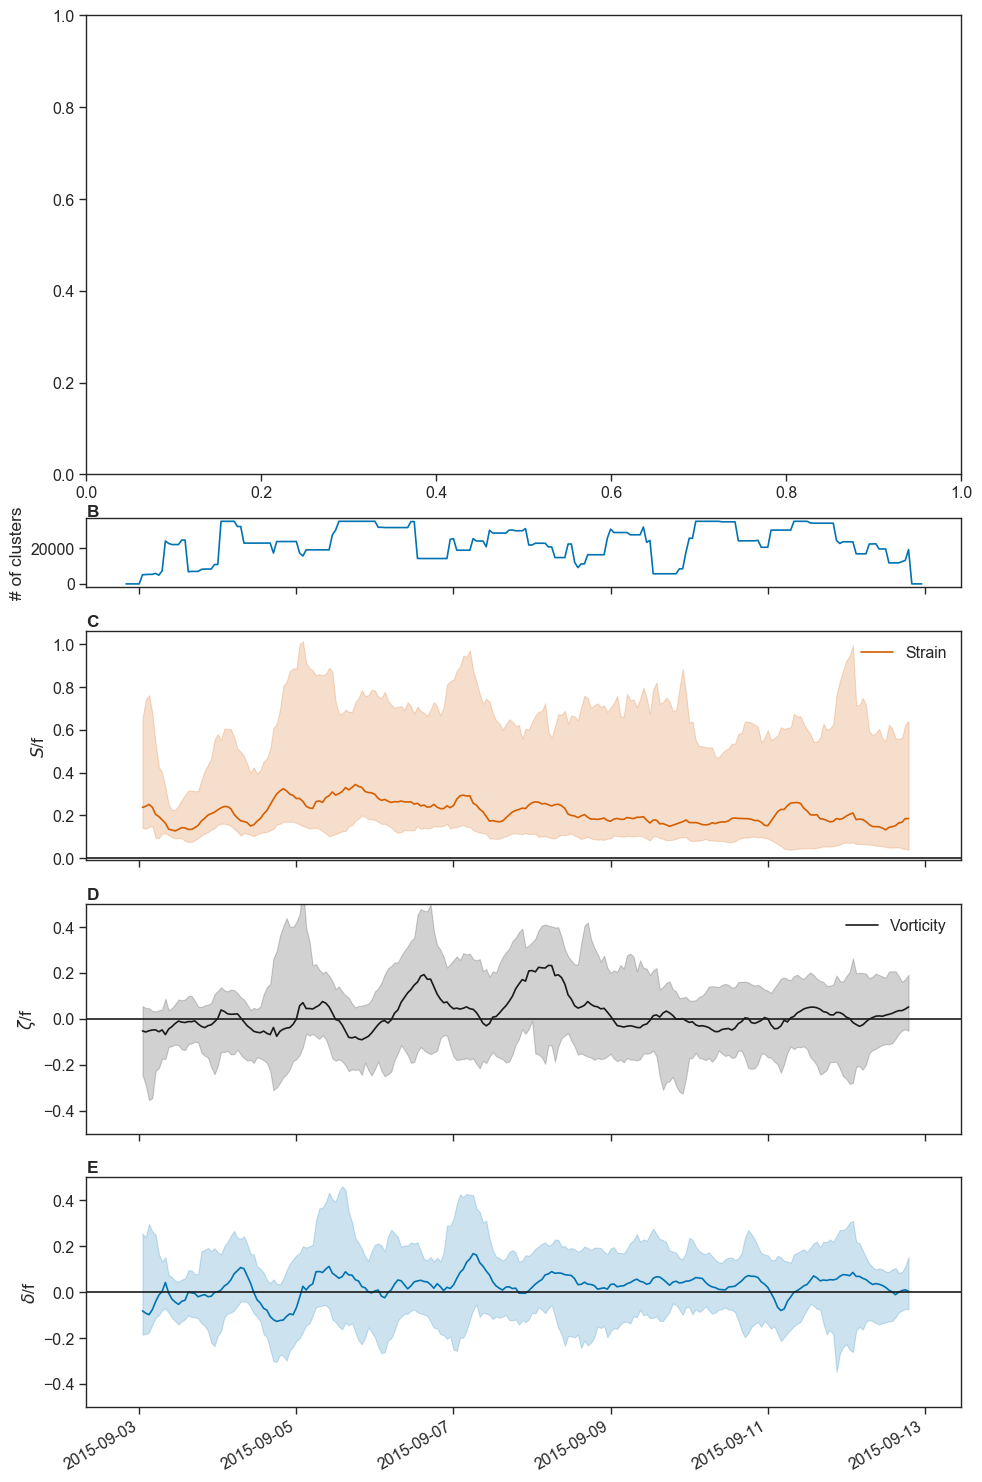

In [146]:
f = plt.figure(figsize=(10,15))
widths = [1]
heights = [2,0.3,1,1,1]
spec = f.add_gridspec(ncols=1,
                      nrows=5,
                      width_ratios=widths,
                      height_ratios=heights)


ax1 = f.add_subplot(spec[0, 0])
dat.maspect.plot(ax=ax0, color='k')
ax0.set_xlabel(None)
plt.setp(ax0.get_xticklabels(), visible=False)
# l, u = get_ci(dat,'aspect')
ax0.fill_between(dat.time.values,la,ua,alpha=0.2,zorder=100, color='b')
ax0.tick_params(axis='y', labelcolor='b')
ax0.set_ylabel(r'Aspect ratio $\alpha$')

ax1 = ax0.twinx()
ax1.tick_params(axis='y', labelcolor='g')
dat.mlength.plot(ax=ax1, color='k')
ax1.set_xlabel(None)
ax1.set_ylabel(r'Length scale L')
# plt.setp(ax1.get_xticklabels(), visible=False)
l, u = get_ci(dat,'length')
ax1.fill_between(dat.time.values,ll,ul,alpha=0.2,zorder=100, color='g')

ax0b = f.add_subplot(spec[1, 0],sharex=ax0)
dat.counts.plot(ax=ax0b)
ax0b.set_xlabel(None)
ax0b.set_ylabel(r'# of clusters')
plt.setp(ax0b.get_xticklabels(), visible=False)

ax2 = f.add_subplot(spec[2, 0],sharex=ax0)
dat.mstrain.plot(label='Strain', ax=ax2, color='r')
# l, u = get_ci(dat,'strain')
ax2.fill_between(dat.time.values,ls,us,
                   alpha=0.2, color='r')
# ax2.set_ylabel('Velocity gradients')
ax2.set_ylabel(r'$S$/f')
plt.setp(ax2.get_xticklabels(), visible=False)
ax2.set_xlabel(None)
ax2.axhline(0,color='k')
ax2.legend()
           
ax3 = f.add_subplot(spec[3, 0],sharex=ax0)           
dat.mvort.plot(label='Vorticity', ax=ax3, color='k')
# l, u = get_ci(dat,'vort')
ax3.fill_between(dat.time.values,lv,uv,
                   alpha=0.2, color='k')
                                               
ax3.legend()
ax3.axhline(0,color='k')
# ax3.set_ylabel('Velocity gradients')
ax3.set_ylabel(r'$\zeta$/f')
ax3.set_xlabel(None)
ax3.set_ylim(-0.5,0.5)
plt.setp(ax3.get_xticklabels(), visible=False)

ax4 = f.add_subplot(spec[4, 0],sharex=ax0)   
dat.mdiv.plot(label='Divergence', ax=ax4, color='b')
# l, u = get_ci(dat,'div')
ax4.fill_between(dat.time.values,ld,ud,
                   alpha=0.2, color='b')  
ax4.axhline(0,color='k')
ax4.set_ylim(-0.5,0.5)
ax4.set_xlabel(None)
ax4.set_ylabel(r'$\delta$/f')
# ax4.legend()

alphabet([ax0,ax0b,ax2,ax3,ax4])

spec.tight_layout(f)
spec.update(hspace=0.18)

plt.savefig('../figures/timeseries_v1.pdf')

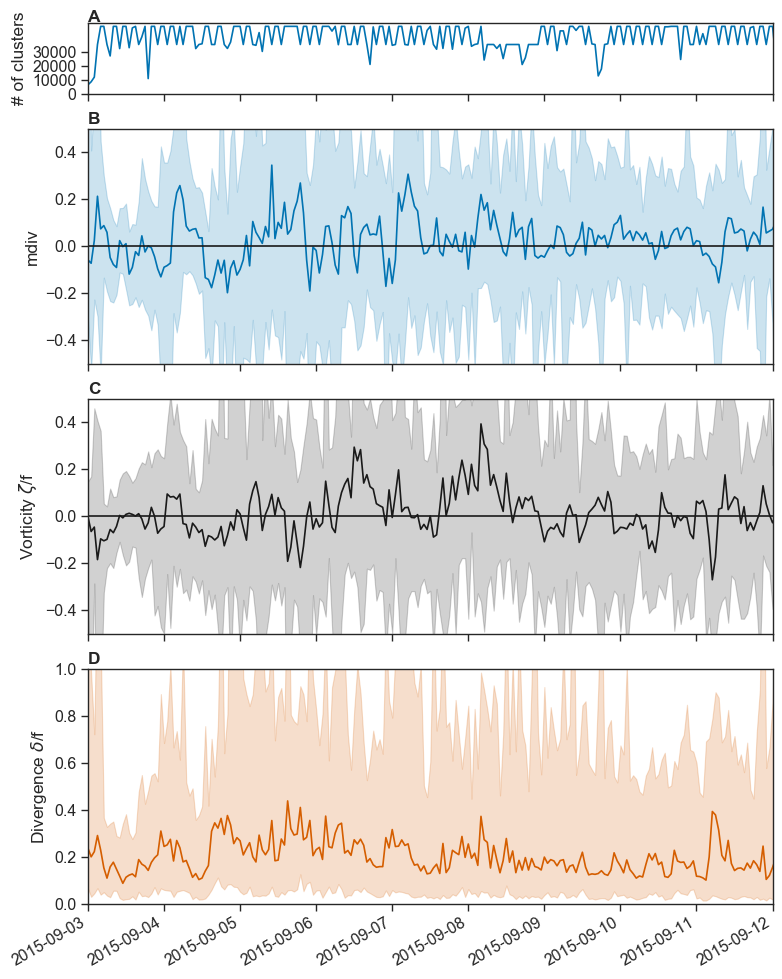

In [47]:
f = plt.figure(figsize=(8,10))
widths = [1]
heights = [0.3,1,1,1]
spec = f.add_gridspec(ncols=1,
                      nrows=4,
                      width_ratios=widths,
                      height_ratios=heights)

ax0b = f.add_subplot(spec[0, 0])
dat.counts.plot(ax=ax0b)
ax0b.set_xlabel(None)
ax0b.set_ylabel(r'# of clusters')
ax0b.set_yticks([0,10000,20000,30000])
plt.setp(ax0b.get_xticklabels(), visible=False)

ax2 = f.add_subplot(spec[1, 0],sharex=ax0b)
dat.mdiv.plot(ax=ax2, color='b')
plt.setp(ax2.get_xticklabels(), visible=False)
ax2.set_xlabel(None)
ax2.fill_between(dat.time.values,ld,ud,
                   alpha=0.2, color='b')  
ax2.axhline(0,color='k')
ax2.set_ylim(-0.5,0.5)
        
ax3 = f.add_subplot(spec[2, 0],sharex=ax0b)           
dat.mvort.plot(ax=ax3, color='k')
ax3.fill_between(dat.time.values,lv,uv,
                   alpha=0.2, color='k')
ax3.axhline(0,color='k')
ax3.set_ylabel(r'Vorticity $\zeta$/f')
ax3.set_xlabel(None)
ax3.set_ylim(-0.5,0.5)
plt.setp(ax3.get_xticklabels(), visible=False)

ax4 = f.add_subplot(spec[3, 0],sharex=ax0b)   
dat.mstrain.plot(ax=ax4, color='r')
ax4.fill_between(dat.time.values,ls,us,
                   alpha=0.2, color='r')
ax4.set_ylabel(r'Lateral strain rate $S$/f')
ax4.set_ylim(0,1)
ax4.set_xlabel(None)
ax4.set_ylabel(r'Divergence $\delta$/f')
ax4.set_xlim('2015-09-03','2015-09-12')

alphabet([ax0b,ax2,ax3,ax4])

spec.tight_layout(f)
spec.update(hspace=0.18)

plt.savefig('../figures/timeseries_v2.pdf')

In [148]:
import gsw
ff = gsw.f(18)

In [149]:
def timef(df):
    import gsw
    ff = gsw.f(18)
    return df*ff

def divf(df):
    import gsw
    ff = gsw.f(18)
    return df/ff

In [150]:
deriv = -dat.mvort.pipe(timef).differentiate('time',datetime_unit='s')/(ff+dat.mvort*ff)

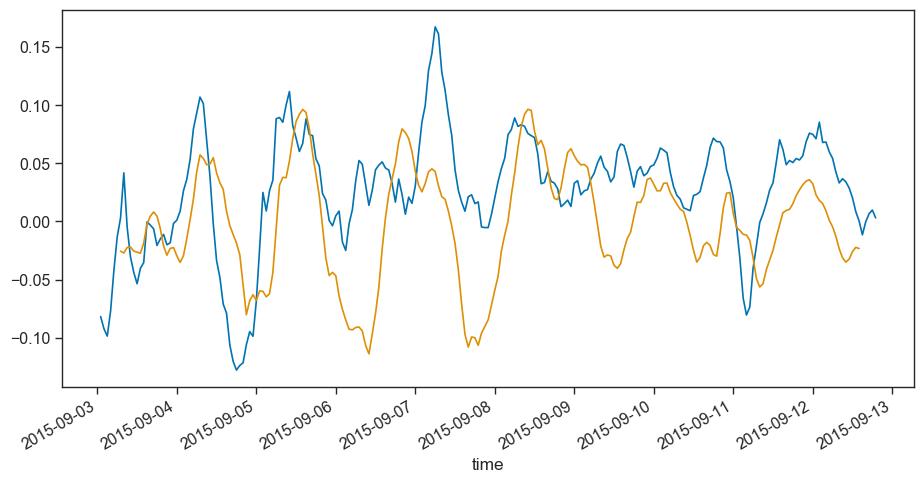

In [162]:
dat.mdiv.plot()
deriv.pipe(divf).rolling({'time':10},center=True).mean().plot()

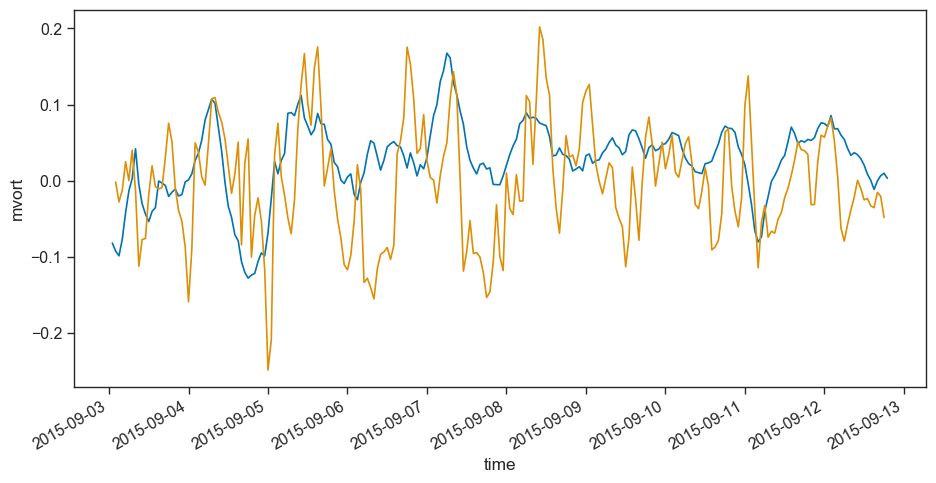

In [154]:
dat.mdiv.plot()
deriv.pipe(divf).plot()

In [169]:
2*np.pi/gsw.f(17)/3600

40.93158129292459